In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 


## Functions

In [2]:
def last_x_weeks(data, week):
    return data[data['last_x_weeks'] == week]

def count_non_zero(column):
    return column[column > 0].count()

#### 1. Load and Inspect Dataset

In [3]:
# Load dataset
data = pd.read_csv('../data/data_analyst.csv')

# Print the first few rows of the dataset
data.head()

,USER_ID,LAST_X_WEEKS,POSTS_CREATED,REPLIES_RECEIVED,THANKYOUS_RECEIVED,EVENTS_CREATED,EVENT_PARTICIPANTS,ITEMS_GIFTED,PLACES_RECOMMENDED
0,1,4,1.0,0.0,6.0,NaN,NaN,NaN,NaN
1,1,6,1.0,0.0,6.0,NaN,NaN,NaN,NaN
2,1,8,1.0,0.0,6.0,NaN,NaN,NaN,NaN
3,1,12,2.0,0.0,6.0,NaN,NaN,NaN,NaN
4,2,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Convert column names to lowercase
data.columns = data.columns.str.lower()

In [5]:
# 80,000 rows in total and activity columns are of type float
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   user_id             80000 non-null  int64  
 1   last_x_weeks        80000 non-null  int64  
 2   posts_created       36101 non-null  float64
 3   replies_received    36101 non-null  float64
 4   thankyous_received  36101 non-null  float64
 5   events_created      5304 non-null   float64
 6   event_participants  5304 non-null   float64
 7   items_gifted        13224 non-null  float64
 8   places_recommended  7127 non-null   float64
dtypes: float64(7), int64(2)
memory usage: 5.5 MB


In [6]:
# print basic summary statistics of the dataset - outliers across all columns except 'last_x_weeks' and 'user_id
data.describe()

,user_id,last_x_weeks,posts_created,replies_received,thankyous_received,events_created,event_participants,items_gifted,places_recommended
count,80000.000000,80000.000000,36101.000000,36101.000000,36101.000000,5304.000000,5304.000000,13224.000000,7127.000000
mean,10000.500000,7.500000,1.560455,2.804438,1.729869,1.747172,2.990196,1.832350,2.558861
std,5773.538769,2.958058,5.300670,5.023577,5.613324,2.073147,3.954328,2.153866,4.221170
min,1.000000,4.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000
25%,5000.750000,5.500000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
50%,10000.500000,7.000000,1.000000,1.000000,0.000000,1.000000,2.000000,1.000000,1.000000
75%,15000.250000,9.000000,2.000000,4.000000,1.000000,2.000000,3.000000,2.000000,2.000000
max,20000.000000,12.000000,698.000000,139.000000,194.000000,36.000000,58.000000,58.000000,155.000000


#### 2. Check Missing Values


In [7]:
# 93% of values missing for events_created/events_participated
missing_values = round(data.isna().sum() / len(data) * 100,2)
missing_values

user_id                0.00
last_x_weeks           0.00
posts_created         54.87
replies_received      54.87
thankyous_received    54.87
events_created        93.37
event_participants    93.37
items_gifted          83.47
places_recommended    91.09
dtype: float64

In [8]:
# missing values by weeks - highest percentage of missing values occur in last 4 weeks across all columns
missing_by_week = data.groupby('last_x_weeks').apply(lambda x: x.isna().sum() / 20000 * 100).drop(columns=['user_id', 'last_x_weeks'])
missing_by_week

/tmp/ipykernel_65183/819509222.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  missing_by_week = data.groupby('last_x_weeks').apply(lambda x: x.isna().sum() / 20000 * 100).drop(columns=['user_id', 'last_x_weeks'])


,posts_created,replies_received,thankyous_received,events_created,event_participants,items_gifted,places_recommended
last_x_weeks,,,,,,,
4,73.980,73.980,73.980,95.755,95.755,90.245,94.775
6,62.485,62.485,62.485,94.410,94.410,86.070,92.570
8,51.755,51.755,51.755,93.120,93.120,82.040,90.635
12,31.275,31.275,31.275,90.195,90.195,75.525,86.385


In [9]:
# Fill missing values with 0 - Assumed that 0 is equivalent to no activity 
data = data.fillna(0)


In [10]:
# Split data into different weeks
last_4_weeks = last_x_weeks(data, 4)
last_6_weeks = last_x_weeks(data, 6)
last_8_weeks = last_x_weeks(data, 8)
last_12_weeks = last_x_weeks(data, 12)

### User Engagement Analysis

##### a. Overall User Activity Count

In [11]:
# Calculate the number of non-zero values in each activity column for the last 12 weeks
activity_columns = ['posts_created', 'replies_received', 'events_created', 'event_participants', 'items_gifted', 'places_recommended', 'thankyous_received']
w4_activity_counts = last_4_weeks[activity_columns].apply(count_non_zero)
w6_activity_counts = last_6_weeks[activity_columns].apply(count_non_zero)
w8_activity_counts = last_8_weeks[activity_columns].apply(count_non_zero)
w12_activity_counts = last_12_weeks[activity_columns].apply(count_non_zero)

# combine the counts into a single DataFrame for better visualization
last_4_week_activity_count = pd.DataFrame(w4_activity_counts, columns=['w4_count']).reset_index().rename(columns={'index': 'activity'}).sort_values(by='w4_count', ascending=False)
last_6_week_activity_count = pd.DataFrame(w6_activity_counts, columns=['w6_count']).reset_index().rename(columns={'index': 'activity'}).sort_values(by='w6_count', ascending=False)
last_8_week_activity_count = pd.DataFrame(w8_activity_counts, columns=['w8_count']).reset_index().rename(columns={'index': 'activity'}).sort_values(by='w8_count', ascending=False)
last_12_week_activity_count = pd.DataFrame(w12_activity_counts, columns=['w12_count']).reset_index().rename(columns={'index': 'activity'}).sort_values(by='w12_count', ascending=False)

# Merge the counts into a single DataFrame
activity_counts = pd.merge(last_4_week_activity_count, last_6_week_activity_count, on='activity')
activity_counts = pd.merge(activity_counts, last_8_week_activity_count, on='activity')
activity_counts = pd.merge(activity_counts, last_12_week_activity_count, on='activity')

# activity_counts.set_index('activity', inplace=True)
activity_counts


,activity,w4_count,w6_count,w8_count,w12_count
0,posts_created,5204,7503,9649,13745
1,replies_received,3172,4654,6035,8821
2,thankyous_received,2128,3211,4279,6364
3,items_gifted,1951,2786,3592,4895
4,places_recommended,1045,1486,1873,2723
5,events_created,849,1118,1376,1961
6,event_participants,825,1076,1328,1901


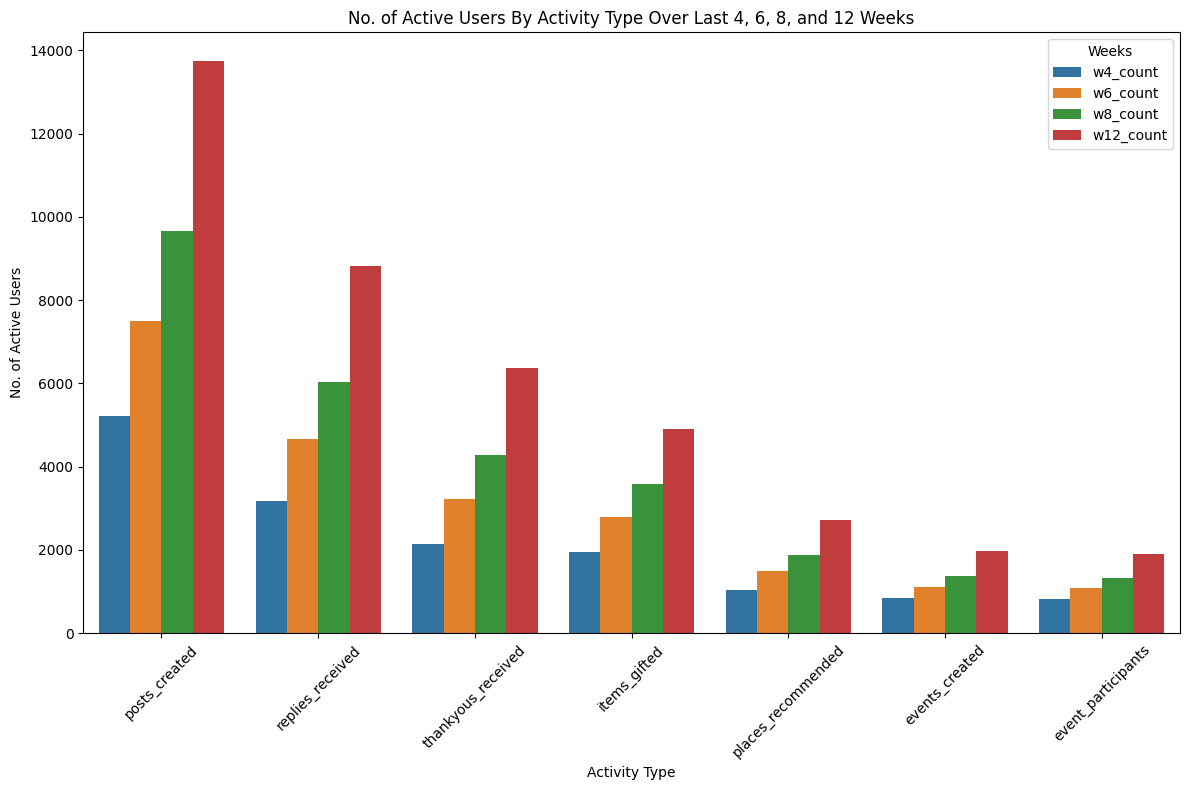

In [12]:
# Plot the activity counts for the last 4, 6, 8, and 12 weeks - highest engagement occurs in last 12 weeks - longest timeframe
plt.figure(figsize=(12, 8))
sns.barplot(data=activity_counts.melt(id_vars='activity'), x='activity', y='value', hue='variable')
plt.title('No. of Active Users By Activity Type Over Last 4, 6, 8, and 12 Weeks')
plt.xlabel('Activity Type')
plt.ylabel('No. of Active Users')
plt.xticks(rotation=45)
plt.legend(title='Weeks', loc='upper right')
plt.tight_layout()


##### b. Distribution Of User Activity Count Per Month

In [53]:
# Create a copy of the last_x_weeks DataFrames to per month
last_4_weeks_pm = last_4_weeks.copy()
last_6_weeks_pm = last_6_weeks.copy()
last_8_weeks_pm = last_8_weeks.copy()
last_12_weeks_pm = last_12_weeks.copy()

# Rename the columns to indicate they are per month
last_4_weeks_pm.columns = [col + '_pm' if col in activity_columns else col for col in last_4_weeks_pm.columns]


In [54]:
# Calculate activity on a per month basis 
for column in activity_columns:
    last_6_weeks_pm[column + '_pm'] = last_6_weeks[column] / 1.5
    last_8_weeks_pm[column + '_pm'] = last_8_weeks_pm[column] / 2
    last_12_weeks_pm[column + '_pm'] = last_12_weeks_pm[column] / 3

# Drop the original activity columns from the per month DataFrames
last_8_weeks_pm = last_8_weeks_pm.drop(columns=activity_columns)
last_6_weeks_pm = last_6_weeks_pm.drop(columns=activity_columns)
last_12_weeks_pm = last_12_weeks_pm.drop(columns=activity_columns)


In [58]:
activity_pm = pd.concat([last_4_weeks_pm, last_6_weeks_pm, last_8_weeks_pm, last_12_weeks_pm]).sort_values(by=['user_id', 'last_x_weeks']).reset_index(drop=True)
activity_pm.groupby('last_x_weeks').mean().drop(columns=['user_id'])

,posts_created_pm,replies_received_pm,thankyous_received_pm,events_created_pm,event_participants_pm,items_gifted_pm,places_recommended_pm
last_x_weeks,,,,,,,
4,0.358450,0.620000,0.402650,0.065450,0.112950,0.164150,0.139750
6,0.367433,0.657333,0.405267,0.061400,0.104967,0.163833,0.129967
8,0.372475,0.666400,0.412200,0.061075,0.104300,0.165325,0.118400
12,0.387383,0.707783,0.429183,0.061217,0.104667,0.157000,0.113450


<Axes: title={'center': 'Average Activity Per Month by Week'}, xlabel='last_x_weeks'>

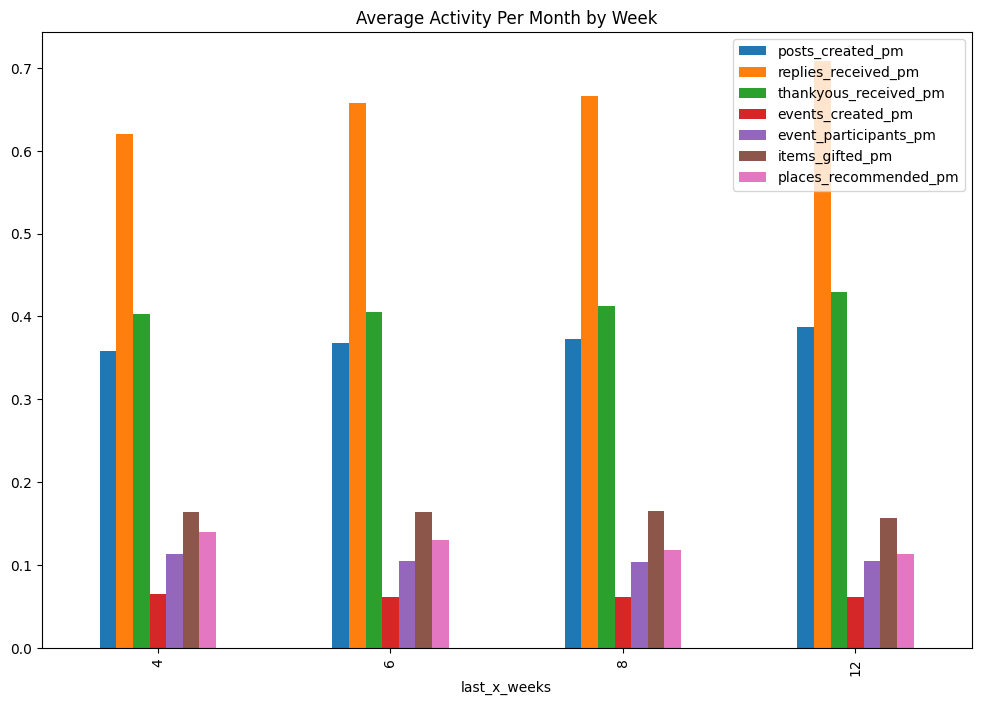

In [57]:
activity_pm.groupby('last_x_weeks').mean().drop(columns=['user_id']).plot(kind='bar', figsize=(12, 8), title='Average Activity Per Month by Week')

KeyError: "Column(s) ['mean', 'std'] do not exist"

In [ ]:
### to differentiate between 6 or 8 weeks, how many users are still active after 8 weeks?

In [16]:
# for column in activity_columns:
#     last_4_weeks_pw[column] = last_4_weeks_pw[column] / last_4_weeks_pw['last_x_weeks']
#     last_6_weeks_pw[column] = last_6_weeks_pw[column] / last_6_weeks_pw['last_x_weeks']
#     last_8_weeks_pw[column] = last_8_weeks_pw[column] / last_8_weeks_pw['last_x_weeks']
#     last_12_weeks_pw[column] = last_12_weeks_pw[column] / last_12_weeks_pw['last_x_weeks']


In [17]:
# # sns.histplot(data=last_4_weeks_pw[last_4_weeks_pw['posts_created'] < last_4_weeks_pw['posts_created'].max()]['posts_created'], bins=20, kde=True, color='blue')
# # sns.histplot(data=last_6_weeks_pw[last_6_weeks_pw['posts_created'] < last_6_weeks_pw['posts_created'].max()]['posts_created'], bins=20, kde=True, color='orange')
# # plt.title('Distribution of Posts Created in Last 4 Weeks')
# # plt.xlabel('Posts Created')
# # plt.ylabel('Frequency')

# # last_4_weeks_pw.describe()

# data['posts_created_pw'] = data['posts_created'] / data['last_x_weeks']
# data['replies_received_pw'] = data['replies_received'] / data['last_x_weeks']
# data['events_created_pw'] = data['events_created'] / data['last_x_weeks']
# data['event_participants_pw'] = data['event_participants'] / data['last_x_weeks']
# data['items_gifted_pw'] = data['items_gifted'] / data['last_x_weeks']
# data['places_recommended_pw'] = data['places_recommended'] / data['last_x_weeks']


# data_pw = data[['user_id', 'last_x_weeks', 'posts_created_pw', 'replies_received_pw', 'events_created_pw', 'event_participants_pw', 'items_gifted_pw', 'places_recommended_pw']]

# sns.boxplot(data=data_pw[data_pw['posts_created_pw'] < 55],x='last_x_weeks', y='posts_created_pw')

In [18]:
# data2 = data_pw[['user_id', 'last_x_weeks', 'posts_created_pw', 'replies_received_pw']]

# # Plot a histogram for each last x week for posts created in subplot 
# fig, axes = plt.subplots(2, 2, figsize=(12, 10))
# sns.histplot(data=data2[data2['last_x_weeks'] == 4], x='posts_created_pw', bins=20, kde=True, ax=axes[0, 0], color='blue')
# sns.histplot(data=data2[data2['last_x_weeks'] == 6], x='posts_created_pw', bins=20, kde=True, ax=axes[0, 1], color='orange')
# sns.histplot(data=data2[data2['last_x_weeks'] == 8], x='posts_created_pw', bins=20, kde=True, ax=axes[1, 0], color='green')
# sns.histplot(data=data2[data2['last_x_weeks'] == 12], x='posts_created_pw', bins=20, kde=True, ax=axes[1, 1], color='purple')
# axes[0, 0].set_title('Posts Created in Last 4 Weeks')
# axes[0, 1].set_title('Posts Created in Last 6 Weeks')
# axes[1, 0].set_title('Posts Created in Last 8 Weeks')
# axes[1, 1].set_title('Posts Created in Last 12 Weeks')


In [19]:
# # Calculate the average activity per week for the last 4 weeks
# w4_activity_per_week = {
#     'posts_created': last_4_weeks_pw['posts_created'].mean(),
#     'replies_received': last_4_weeks_pw['replies_received'].mean(),
#     'events_created': last_4_weeks_pw['events_created'].mean(),
#     'event_participants': last_4_weeks_pw['event_participants'].mean(),
#     'items_gifted': last_4_weeks_pw['items_gifted'].mean(),
#     'places_recommended': last_4_weeks_pw['places_recommended'].mean()
# }

# # Calculate the average activity per week for each activity type for the last 6 weeks
# w6_activity_per_week = {
#     'posts_created': last_6_weeks_pw['posts_created'].mean(),
#     'replies_received': last_6_weeks_pw['replies_received'].mean(),
#     'events_created': last_6_weeks_pw['events_created'].mean(),
#     'event_participants': last_6_weeks_pw['event_participants'].mean(),
#     'items_gifted': last_6_weeks_pw['items_gifted'].mean(),
#     'places_recommended': last_6_weeks_pw['places_recommended'].mean()
# }

# # Calculate the average activity per week for each activity type for the last 8 weeks
# w8_activity_per_week = {
#     'posts_created': last_8_weeks_pw['posts_created'].mean(),
#     'replies_received': last_8_weeks_pw['replies_received'].mean(),
#     'events_created': last_8_weeks_pw['events_created'].mean(),
#     'event_participants': last_8_weeks_pw['event_participants'].mean(),
#     'items_gifted': last_8_weeks_pw['items_gifted'].mean(),
#     'places_recommended': last_8_weeks_pw['places_recommended'].mean()
# }

# # Calculate the average activity per week for each activity type for the last 12 weeks
# w12_activity_per_week = {
#     'posts_created': last_12_weeks_pw['posts_created'].mean(),
#     'replies_received': last_12_weeks_pw['replies_received'].mean(),
#     'events_created': last_12_weeks_pw['events_created'].mean(),
#     'event_participants': last_12_weeks_pw['event_participants'].mean(),
#     'items_gifted': last_12_weeks_pw['items_gifted'].mean(),
#     'places_recommended': last_12_weeks_pw['places_recommended'].mean()
# }

# activity_pw = pd.DataFrame({
#     'last_4_weeks': w4_activity_per_week,
#     'last_6_weeks': w6_activity_per_week,
#     'last_8_weeks': w8_activity_per_week,
#     'last_12_weeks': w12_activity_per_week
# }).T


# activity_pw = activity_pw.reset_index().rename(columns={'index': 'activity'})

# # Plot the average activity per week for the last 4, 6, 8, and 12 weeks
# plt.figure(figsize=(12, 8))
# sns.lineplot(data=activity_pw.melt(id_vars='activity'), x='activity', y='value', hue='variable', marker='o')
# plt.title('Average Activity Per Week for Last 4, 6, 8, and 12 Weeks')
# plt.xlabel('Activity Type')
# plt.ylabel('Average Count Per Week')
# plt.xticks(rotation=45)
# plt.legend(title='Weeks', loc='upper right')
# plt.tight_layout()